# Hierarchical Models

In [1]:
import collections
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sstats
import pandas as pd
import pymc3 as pm
import pyjags

import plot_utils

In [2]:
%load_ext autoreload

%autoreload 2

# Exercise 1

Therapoetic touch data with different priors

## Question A + B

Compare vague gamma distributed priors with different parameters.

In [3]:
# Calculations are based on info from wikipedia
# http://en.wikipedia.org/wiki/Gamma_distribution

GammaParams = collections.namedtuple('GammaParams', ['shape', 'scale'])


def gamma_params_from_mean_and_sd(mean, sd):
    return GammaParams((mean / sd) ** 2, sd ** 2 / mean)


def gamma_params_from_mode_and_sd(mode, sd):
    scale = ((mode ** 2 + 4 * sd ** 2) ** 0.5 - mode) / 2
    shape = (sd / scale) ** 2
    return GammaParams(shape, scale)

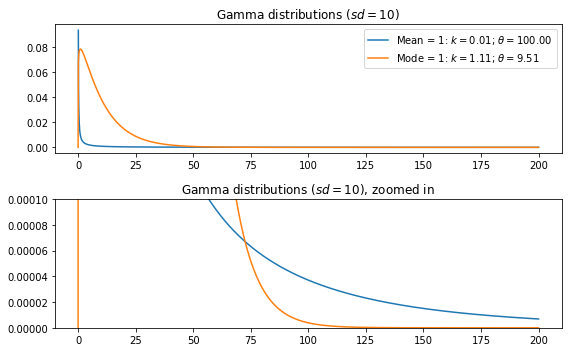

In [4]:
def plot_gammas(x, *gamma_params_list, legend_prefixes=(), ax=None):
    if ax is None:
        ax = plt.gca()

    for gamma_params, prefix in itertools.zip_longest(gamma_params_list, legend_prefixes):
        text = r'$k = {shape:.2f}$; $\theta = {scale:.2f}$'.format_map(gamma_params._asdict())
        if prefix:
            text = f'{prefix}: {text}'
        ax.plot(x, sstats.gamma(gamma_params.shape, scale=gamma_params.scale).pdf(x), label=text)
        
    return ax


gammas = [
    gamma_params_from_mean_and_sd(1, 10),
    gamma_params_from_mode_and_sd(1, 10),
]

_, axes = plt.subplots(nrows=2, figsize=(8, 5))

x = np.linspace(0, 200, 2000)

ax = axes[0]
plot_gammas(x, *gammas, legend_prefixes=('Mean = 1', 'Mode = 1'), ax=ax)
title = 'Gamma distributions $(sd = 10)$'
ax.legend()
ax.set(title=title)

ax = axes[1]
plot_gammas(x, *gammas, ax=ax)
ax.set(ylim=(0, .0001), title=title + ', zoomed in')

plt.tight_layout()

The gamma distribution with mode = 1 favors values between 0.1 and 75.

The gamma distribution with mean = 1 favors very small values or those larger than 75.

## Question C

Notice how the different priors generate similar posteriors.

In [5]:
data = pd.read_csv('data/therapeutic_touch_data.csv')

In [6]:
CHAINS = 4

### PyMC3

In [7]:
def run_pymc3_model_with_gamma_params(gamma_params, data, *, sample_prior=False):
    
    subjects = data['s'].unique()
    
    with pm.Model():
        
        # Higher level parameters
        omega = pm.Beta('omega', 1, 1)
        # PyMC3 works with rate parameter instead of scale parameter
        kappa = pm.Gamma('kappa', gamma_params.shape, 1 / gamma_params.scale) + 2

        # Lower level parameters
        subject_theta = pm.Beta(
            'theta',
            omega * (kappa - 2) + 1,
            (1 - omega) * (kappa - 2) + 1,
            shape=(len(subjects), 1),
        )

        # Subjects data
        if not sample_prior:
            subjects_data = [data['y'][data['s'] == s].values for s in subjects]
            pm.Bernoulli(
                'y',
                subject_theta,
                observed=subjects_data,
            )

        # Inference
        # Aiming for >10k effective sample size on higher level params
        trace = pm.sample(15_000, chains=CHAINS)

    return trace

Mean of 1 and standard deviation of 10.

In [8]:
%%time

gamma_params = gamma_params_from_mean_and_sd(1, 10)
trace = run_pymc3_model_with_gamma_params(gamma_params, data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta, kappa, omega]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 89 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


CPU times: user 22.5 s, sys: 1.82 s, total: 24.3 s
Wall time: 1min 40s


[Text(0.5, 0, '$\\kappa$')]

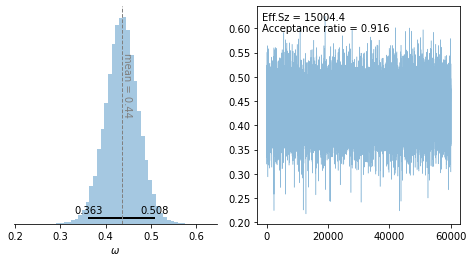

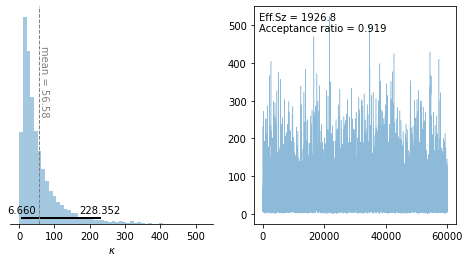

In [9]:
axes = plot_utils.trace(trace.get_values('omega'))
axes[0].set(xlabel=r'$\omega$')
axes = plot_utils.trace(trace.get_values('kappa'))
axes[0].set(xlabel=r'$\kappa$')

Mode of 1 and standard deviation of 10.

In [10]:
%%time

gamma_params = gamma_params_from_mode_and_sd(1, 10)
trace = run_pymc3_model_with_gamma_params(gamma_params, data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta, kappa, omega]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 70 seconds.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 23.1 s, sys: 1.92 s, total: 25 s
Wall time: 1min 18s


[Text(0.5, 0, '$\\kappa$')]

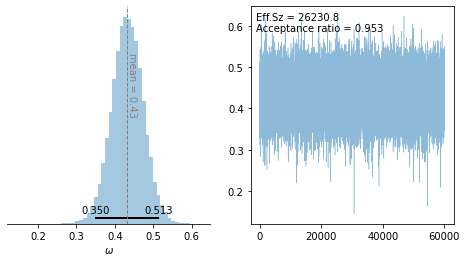

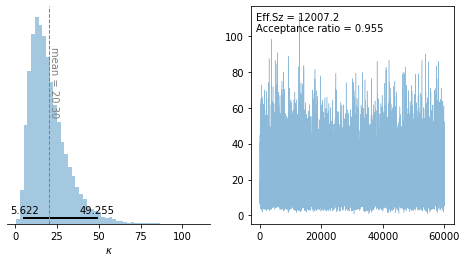

In [11]:
axes = plot_utils.trace(trace.get_values('omega'))
axes[0].set(xlabel=r'$\omega$')
axes = plot_utils.trace(trace.get_values('kappa'))
axes[0].set(xlabel=r'$\kappa$')

### Now with pyjags

In [12]:
code = """
model {
    for (s in 1:Nsubj) {
        z[s] ~ dbin(theta[s], N[s])
        theta[s] ~ dbeta(omega * (kappa - 2) + 1, (1 - omega) * (kappa - 2) + 1)
    }
    omega ~ dbeta(1, 1)
    kappa <- kappaMinusTwo + 2
    kappaMinusTwo ~ dgamma(shape, 1 / scale)
}
"""

jags_data = {
    'Nsubj': len(data['s'].unique()),
    'N': data.groupby('s')['y'].count().values,
    'z': data.groupby('s')['y'].sum().values,
}

In [13]:
def run_jags_model_with_gamma_params(code, data, params):
    data['shape'] = params.shape
    data['scale'] = params.scale
    model = pyjags.Model(code=code, data=data, chains=CHAINS)
    return model.sample(
        vars=['theta', 'omega', 'kappa'],
        iterations=40_000,  # Aiming for >10k effective sample size on higher level params
    )

Mean of 1 and standard deviation of 10.

In [14]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
trace = run_jags_model_with_gamma_params(code, jags_data, gamma_params)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 86816 of 160000, elapsed 0:00:08, remaining 0:00:07
sampling: iterations 160000 of 160000, elapsed 0:00:15, remaining 0:00:00
sampling: iterations 160000 of 160000, elapsed 0:00:15, remaining 0:00:00


[Text(0.5, 0, '$\\kappa$')]

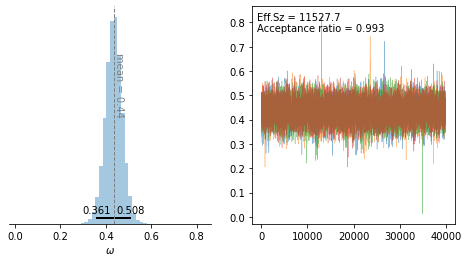

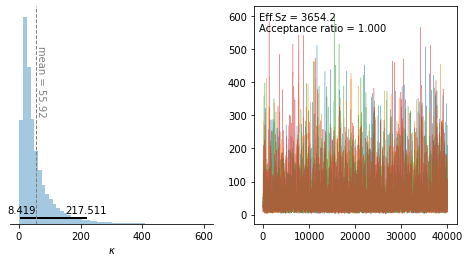

In [15]:
axes = plot_utils.trace(trace['omega'][0])
axes[0].set(xlabel=r'$\omega$')
axes = plot_utils.trace(trace['kappa'][0])
axes[0].set(xlabel=r'$\kappa$')

Mode of 1 and standard deviation of 10.

In [16]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
trace = run_jags_model_with_gamma_params(code, jags_data, gamma_params)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 65532 of 160000, elapsed 0:00:07, remaining 0:00:11
sampling: iterations 109716 of 160000, elapsed 0:00:12, remaining 0:00:06
sampling: iterations 153788 of 160000, elapsed 0:00:18, remaining 0:00:01
sampling: iterations 160000 of 160000, elapsed 0:00:18, remaining 0:00:00


[Text(0.5, 0, '$\\kappa$')]

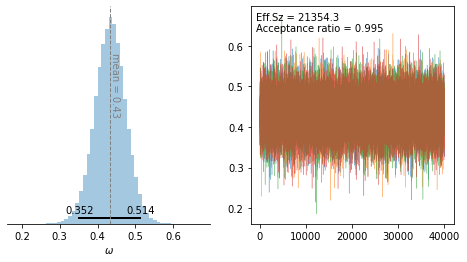

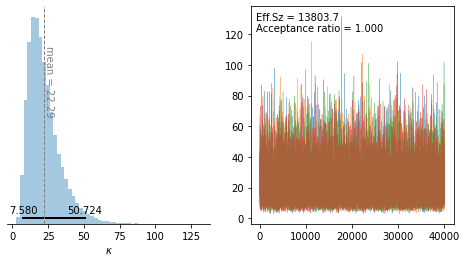

In [17]:
axes = plot_utils.trace(trace['omega'][0])
axes[0].set(xlabel=r'$\omega$')
axes = plot_utils.trace(trace['kappa'][0])
axes[0].set(xlabel=r'$\kappa$')

## Question D

The posterior for $\kappa$ changed by changing the prior from `mean=1, sd=10` to `mode=1, sd=10`. First of all, the effective sample size grew significantly. With 160,000 samples, the ESS when `mean=1` is ~3k, while with `mode=1` it's ~14k (refering to the `pyjags` trace here).

Question: "For which prior does the marginal posterior distribution on $\kappa$ have a bigger large-value tail?"

For the `mean=1` prior $\kappa$ has a bigger large-value tail.

Question: "When $\kappa$ is larger, what effect does that have on shrinkage of the thetas values?"

When $\kappa$ is larger the subjects' $\theta$s are expected to shift closer to the higher level parameter $\omega$, resulting in more shrinkage.

## Question E

See next exercise.

# Exercise 2

Examine the priors implied on lower level parameters with `mean=1` vs. `mode=1` for higher level parameter.

In [18]:
def plot_param_comparison(trace, param, comparison):
    n = len(comparison)
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(8, 8))

    x = trace[param]

    sample = np.random.randint(len(x[-1]), size=30)

    for i, first in enumerate(comparison):
        plot_utils.dist(x[first], ax=axes[i, i])
        axes[i, i].set(title=f'{param}[{first}]')
        for j, second in enumerate(comparison[i + 1:], start=i + 1):
            plot_utils.dist(x[first] - x[second], ax=axes[i, j])
            axes[i, j].set(title=f'{param}[{first}] - {param}[{second}]')
            axes[j, i].scatter(x[first][sample], x[second][sample])
            axes[j, i].set(xlabel=f'{param}[{first}]', ylabel=f'{param}[{second}]')

    fig.tight_layout()

In [19]:
prior_data = jags_data.copy()
del prior_data['z']

Mean of 1 and standard deviation of 10.

In [20]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
trace = run_jags_model_with_gamma_params(code=code, data=prior_data, params=gamma_params)

sampling: iterations 160000 of 160000, elapsed 0:00:01, remaining 0:00:00


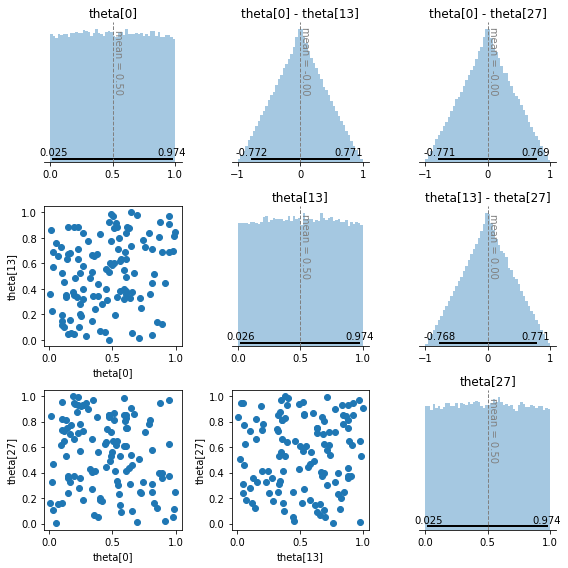

In [21]:
plot_param_comparison(trace, 'theta', [0, 13, 27])

Mode of 1 and standard deviation of 10.

In [22]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
trace = run_jags_model_with_gamma_params(code=code, data=prior_data, params=gamma_params)

sampling: iterations 160000 of 160000, elapsed 0:00:01, remaining 0:00:00


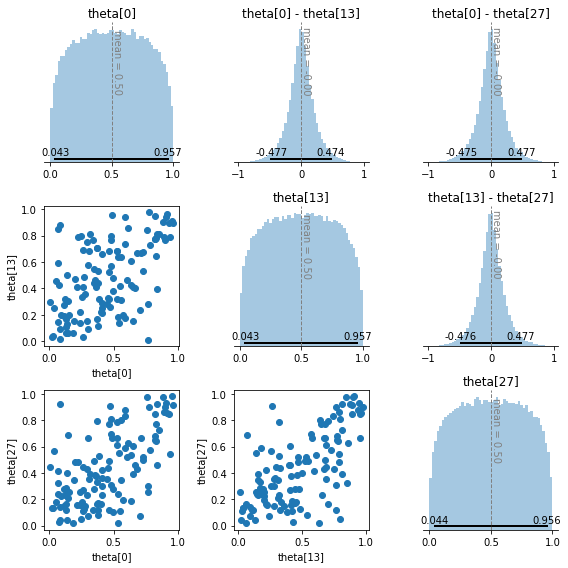

In [23]:
plot_param_comparison(trace, 'theta', [0, 13, 27])

## Question A

With `mode=1` the lower level parameters are rounded. This is because $\kappa$ can be large, constraining the lower level parameters to stay close to the higher level $\omega$ parameter.

## Question B

If we are fine with having a bias towards chance performance, having `mean=1` is fine. If we want not to have bias for individuals it's better to use `mode=1`.

# Exercise 3

In [24]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
trace = run_jags_model_with_gamma_params(code=code, data=jags_data, params=gamma_params)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 98616 of 160000, elapsed 0:00:09, remaining 0:00:06
sampling: iterations 160000 of 160000, elapsed 0:00:14, remaining 0:00:00
sampling: iterations 160000 of 160000, elapsed 0:00:14, remaining 0:00:00


In [25]:
percentage_correct = data.groupby('s')['y'].mean()
estimates = [theta.mean() for theta in trace['theta']]

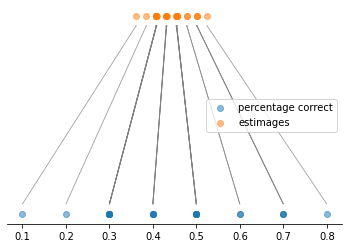

In [26]:
plot_utils.shrinkage(percentage_correct, estimates)

Bayesian analysis provides priors, with specific beliefes about the data and underlying parameters. Shrinkage is affecte by both the priors and the data. With MLE, shrinkage is only affected by the data (and the model structure of course).